# 04 Multiple Linear regression model 

> k-fold cross validation of regression model choice   

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [6]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [7]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507,77.360723,0.001138


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`

In [ ]:
# Potential covariates 
covar_opt = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']

This performs 5 fold cross-validation to determine the best combination of covariates. 

In [8]:
#|export 

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 5
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,9):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_plus[list(subset)].values.reshape(-1,i)
        # evaluate the model using 5-fold CV 
        scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [9]:
# Best combination of covariates
covar_comb[max(perform_by_covar, key=perform_by_covar.get)]

('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc')

In [10]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7711839280264934",
 "Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.7711196881520099",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7708235715056528",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.7704441074351094",
 "Covariates:('over_65_pc', 'STIA_afflicted_pc'), Accuracy:0.7702740457309754"]

In [11]:
# Create dataframe of combinations of covariates
df_covar_comb = pd.DataFrame.from_dict(covar_comb, orient='index')
df_covar_comb.columns = ['covariate 1', 'covariate 2', 'covariate 3', 'covariate 4', 'covariate 5', 'covariate 6', 'covariate 7', 'covariate 8']

# Create dataframe of accuracy
df_accuracy = pd.DataFrame.from_dict(perform_by_covar, orient='index')
df_accuracy.rename(columns={0:'accuracy (mean)'}, inplace=True)

# Merge 
df_model_acc = pd.merge(df_accuracy, df_covar_comb, left_index=True, right_index=True)

In [12]:
# This dataframe records the model accuracy for every combination of covariates 
df_model_acc

,accuracy (mean),covariate 1,covariate 2,covariate 3,covariate 4,covariate 5,covariate 6,covariate 7,covariate 8
0,0.743587,over_65_pc,None,None,None,None,None,None,None
1,-0.055047,female_pc,None,None,None,None,None,None,None
2,0.116131,ALevel_plus_pc,None,None,None,None,None,None,None
3,0.549307,white_pc,None,None,None,None,None,None,None
4,0.637414,HYP_afflicted_pc,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
250,0.767015,over_65_pc,female_pc,ALevel_plus_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
251,0.768299,over_65_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
252,0.767544,over_65_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
253,0.745420,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None


How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [13]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [14]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-60]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Wycombe',
 'Chiltern',
 'South Northamptonshire',
 'Aylesbury Vale',
 'South Bucks']

2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

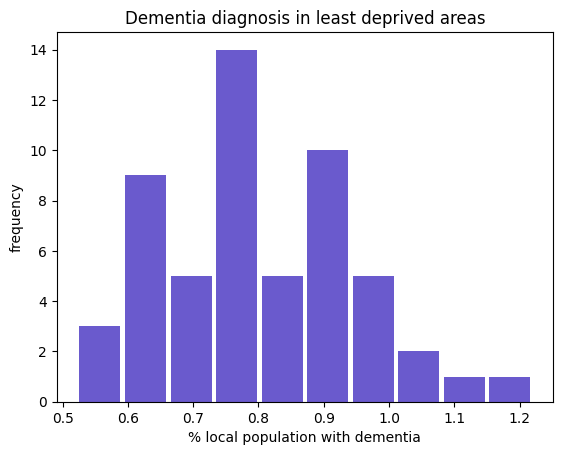

In [15]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = 100*df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

In [16]:
# # Potential covariates 
# covar_opt = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']

# # Outcome data 
# Y_data = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

# # Parameters for cross validation 
# n_folds = 2
# cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# # Model 
# model = linear_model.LinearRegression()

# covar_comb = {}
# perform_by_covar = {}

# key_num = 0
# for i in range(1,8):
#     for j, subset in enumerate(itertools.combinations(covar_opt, i)):
#         covar_comb[key_num] = subset
#         X_data = df_dem_topIMD[list(subset)].values.reshape(-1,i)
#         model.fit(X=X_data, y=Y_data)
#         scores = model.score(X=X_data, y=Y_data)
#         # evaluate the model using 5-fold CV 
#         #scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
#         perform_by_covar[key_num] = np.mean(scores)
#         key_num += 1
#         #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [17]:
# # Top 5 combination of covariates 
# max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
# [f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.5531660807893286",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.5520304533164041",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.5520251903251985",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.5483049320170065",
 "Covariates:('over_65_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.5475231474614825"]

In [18]:
# Multiple linear regression including all the covariates 

x_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# residuals 
all_var_residuals = true_val-y_pred_all

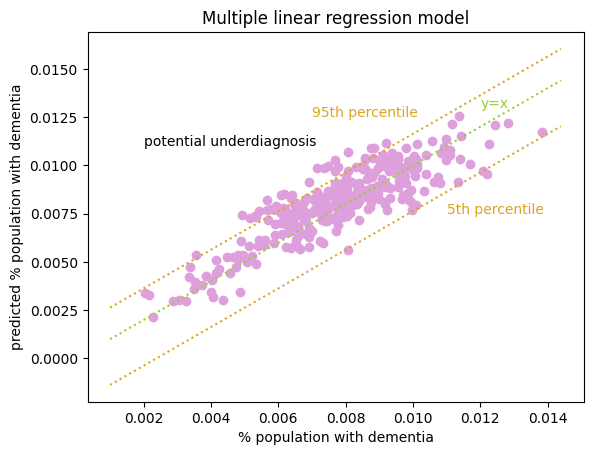

In [19]:
# 5th and 95th perctile of the residuals 
ci_5, ci_95 = np.abs(st.norm.interval(confidence=0.95, 
                 loc=np.mean(all_var_residuals), 
                 scale=np.std(all_var_residuals)))

x_vals = np.arange(0.001, 0.0145, 0.0001)

plt.plot(x_vals, x_vals, ':', color='yellowgreen') # y=x line 
plt.plot(x_vals, x_vals-ci_5, ':', color='goldenrod')
plt.plot(x_vals, x_vals+ci_95, ':', color='goldenrod')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.011, 0.0075, r'5th percentile', fontsize=10, color='goldenrod')
plt.text(0.007, 0.0125, r'95th percentile', fontsize=10, color='goldenrod')
plt.text(0.002, 0.011, r'potential underdiagnosis', fontsize=10)
plt.show()

In [20]:
# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[-all_var_residuals>ci_95]['area_name']
#[x for x in list(resid_gap_area)]
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

['Telford and Wrekin',
 'South Somerset',
 'Medway',
 'South Hams',
 'Knowsley',
 'Isles of Scilly',
 'Worcester',
 'Swale',
 'Redditch',
 'Wychavon',
 'East Cambridgeshire',
 'Tamworth',
 'Swindon',
 "King's Lynn and West Norfolk",
 'Ealing',
 'Scarborough',
 'Somerset West and Taunton',
 'Sandwell',
 'Broxbourne',
 'South Norfolk',
 'North Lincolnshire',
 'Basildon',
 'South Cambridgeshire',
 'Eden',
 'Havering',
 'Thanet',
 'Fenland',
 'Torridge',
 'Plymouth',
 'Nuneaton and Bedworth']

What happens if I include all possible covariates?

In [22]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

In [23]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.0025377274071593584
-------- 
 coefficients of independent variables 
 
over_65_pc:0.016222644691388975 

female_pc:0.006458668934371678 

ALevel_plus_pc:-0.006027849410573262 

white_pc:-0.004512537715695548 

HYP_afflicted_pc:0.010121593294667754 

DM_afflicted_pc:-0.024289787722671315 

STIA_afflicted_pc:0.23589687853973476 



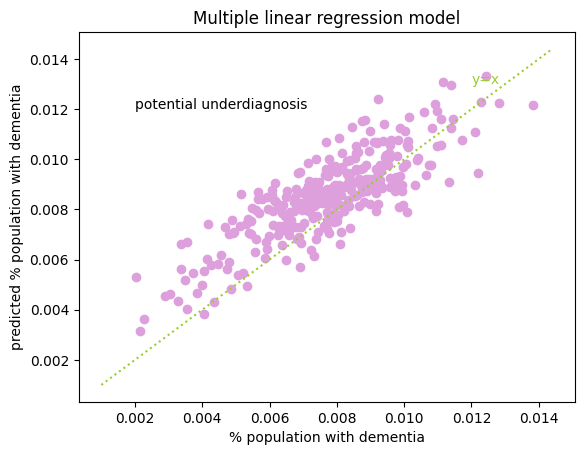

In [24]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.002, 0.012, r'potential underdiagnosis', fontsize=10)
plt.show()

In [25]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.0025377274071593584
-------- 
 coefficients of independent variables 
 
over_65_pc:0.016222644691388975 

female_pc:0.006458668934371678 

ALevel_plus_pc:-0.006027849410573262 

white_pc:-0.004512537715695548 

HYP_afflicted_pc:0.010121593294667754 

DM_afflicted_pc:-0.024289787722671315 

STIA_afflicted_pc:0.23589687853973476 



NOTE: need to look into DM_afflicted as seems to have a negative correlation - but analysis of just dementia and diabetes found a positive correlation? 

In [26]:
# residuals 
all_var_residuals = y_pred_all-true_val

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[all_var_residuals>0.003]['area_name']
[x for x in list(resid_gap_area)]

['Barking and Dagenham',
 'Slough',
 'Redditch',
 'Ealing',
 'Sandwell',
 'Eden',
 'Newham',
 'Torridge']

In [27]:
df_covar_comb

,covariate 1,covariate 2,covariate 3,covariate 4,covariate 5,covariate 6,covariate 7,covariate 8
0,over_65_pc,None,None,None,None,None,None,None
1,female_pc,None,None,None,None,None,None,None
2,ALevel_plus_pc,None,None,None,None,None,None,None
3,white_pc,None,None,None,None,None,None,None
4,HYP_afflicted_pc,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
250,over_65_pc,female_pc,ALevel_plus_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
251,over_65_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
252,over_65_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
253,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None


In [42]:
all_var_residuals = all_var_residuals.reshape(309)
worst_5_resid = np.argsort(all_var_residuals)[-5:]
df_dem_plus.iloc[worst_5_resid, :][['area_name', 'DEM_afflicted_pc', 'over_65_pc', 'ALevel_plus_pc', 'female_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']]

,area_name,DEM_afflicted_pc,over_65_pc,ALevel_plus_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
286,Torridge,0.009208,0.337473,0.436340,0.605957,0.961,0.171561,0.067177,0.031117,0.001911
21,Barking and Dagenham,0.003375,0.122907,0.486063,0.720651,0.309,0.107855,0.065709,0.009560,0.001666
73,Slough,0.004162,0.140203,0.524870,0.725992,0.240,0.128130,0.080179,0.012005,0.001538
284,Newham,0.002035,0.091862,0.530688,0.632619,0.148,0.096223,0.067833,0.007406,0.002037
197,Sandwell,0.005148,0.196423,0.392560,0.680682,0.521,0.145298,0.076929,0.015282,0.001068


In [ ]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
36,E06000039,Slough,19788.26,73,22.965,103,0.0000,195,0.1122,152,27534.97,172
85,E07000046,Torridge,20086.96,67,23.269,99,0.0000,195,0.1025,160,27564.45,171
237,E07000236,Redditch,17343.30,118,22.524,107,0.0909,86,0.2596,80,30212.17,104
271,E08000025,Birmingham,25319.55,6,38.067,7,0.4131,7,0.5792,4,32208.16,30
274,E08000028,Sandwell,25276.49,8,34.884,12,0.1989,44,0.5349,10,31705.52,53
285,E09000002,Barking and Dagenham,25551.85,5,32.768,21,0.0364,139,0.4724,20,29391.87,125
288,E09000005,Brent,21083.02,49,25.558,79,0.0578,116,0.2074,101,29908.65,114
292,E09000009,Ealing,18991.69,88,22.710,105,0.0204,163,0.1630,127,28827.66,143
308,E09000025,Newham,24138.70,12,29.577,43,0.0244,154,0.2884,67,28987.07,137


In [ ]:
df_dem_plus['residual'] = all_var_residuals

In [ ]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [ ]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [ ]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,residual,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487,215.158147,0.001420,-0.000043,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880,437.450820,0.002790,-0.000556,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880,123.466346,0.001299,-0.000982,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488,612.399689,0.004970,-0.002382,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507,77.360723,0.001138,0.001630,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,0.565297,0.232554,0.676405,0.132918,0.056508,0.016021,222.131324,0.002679,0.000100,224
299,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,0.411796,0.247559,0.617093,0.173991,0.068221,0.023566,398.125138,0.001740,0.001447,33
300,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,0.559917,0.270614,0.649017,0.152340,0.057917,0.020497,293.938550,0.001043,0.001186,183
301,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,0.587487,0.289789,0.622941,0.148191,0.047888,0.020728,117.926289,0.001634,-0.000711,294


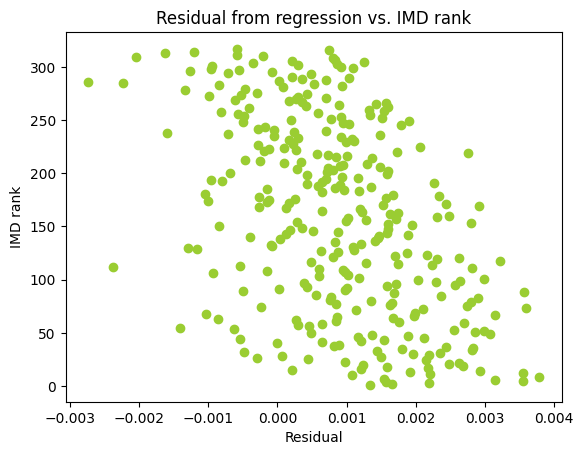

In [ ]:
plt.scatter(df_dem_plus_IMD['residual'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

In [ ]:
len(df_dem_plus)

306

### Ridge regression 

In [ ]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']].values.reshape(-1,8)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

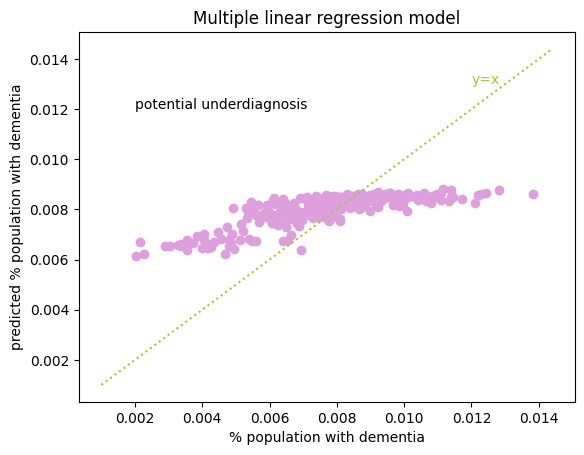

In [ ]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.002, 0.012, r'potential underdiagnosis', fontsize=10)
plt.show()

In [ ]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.006187459649924365
-------- 
 coefficients of independent variables 
 
over_65_pc:0.001333940480761011 

female_pc:-0.00013641543418449928 

ALevel_plus_pc:-0.0010366077131883891 

white_pc:0.0025570057968104716 

HYP_afflicted_pc:0.0007047830406691216 

DM_afflicted_pc:0.0001620908205827119 

STIA_afflicted_pc:0.00013738860022166095 



### Lasso regression 

In [ ]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']].values.reshape(-1,8)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

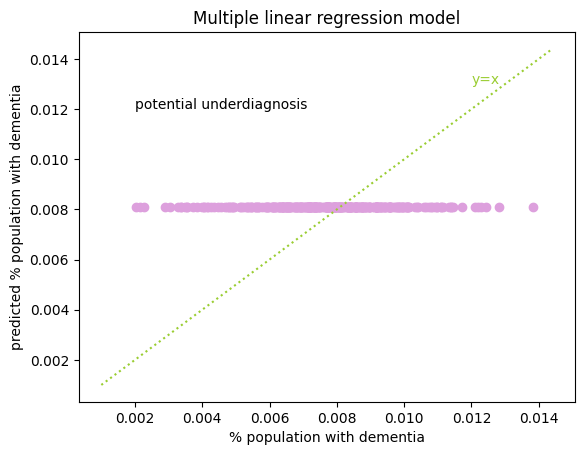

In [ ]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.002, 0.012, r'potential underdiagnosis', fontsize=10)
plt.show()

In [ ]:
regr.coef_[0]

0.0

In [ ]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.008088468442761352
-------- 
 coefficients of independent variables 
 
over_65_pc:0.0 

female_pc:-0.0 

ALevel_plus_pc:-0.0 

white_pc:0.0 

HYP_afflicted_pc:0.0 

DM_afflicted_pc:0.0 

STIA_afflicted_pc:0.0 

GP_LAD_pc:-0.0 

